In [1]:
%load_ext autoreload
%autoreload 2
import os
import argparse
import time
from datetime import datetime, date
import random

import numpy as np
from scipy.sparse import load_npz
from scipy.stats import pearsonr
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import pandas as pd

import torch
import torch_geometric
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

from model_classes_ import GCN_classification, GCN_regression
from baseline_mdl_classes import MLP_classification, MLP_regression

# EDA

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
cell_line = 'E116'
max_epoch = 1000
learning_rate = 1e-4
num_graph_conv_layers = 2
graph_conv_embed_size = 256
num_lin_layers = 3
lin_hidden_size = 256
regression_flag = 0
random_seed = 0

chip_res = 10000
hic_res = 10000
num_hm = 6
num_feat = int((hic_res/chip_res)*num_hm)
num_classes = 2 if regression_flag == 0 else 1

In [4]:
base_path = os.getcwd()
os.path.dirname(base_path), base_path

('/home/vvenkatesh/private/Capstone_MT_Q1_Proj/GC-MERGE/src',
 '/home/vvenkatesh/private/Capstone_MT_Q1_Proj/GC-MERGE/src/midterm_submission')

In [5]:
base_path = os.getcwd()
src_dir = os.path.dirname(base_path)
save_dir = os.path.join(src_dir, 'data', cell_line, 'saved_runs')
hic_sparse_mat_file = os.path.join(src_dir, 'data', cell_line, 'hic_sparse.npz')
np_nodes_lab_genes_file = os.path.join(src_dir, 'data',  cell_line, \
    'np_nodes_lab_genes_reg' + str(regression_flag) + '.npy')
np_hmods_norm_all_file = os.path.join(src_dir, 'data', cell_line, \
    'np_hmods_norm_chip_' + str(chip_res) + 'bp.npy')
df_genes_file = os.path.join(src_dir, 'data', cell_line, 'df_genes_reg' + str(regression_flag) + '.pkl')
df_genes = pd.read_pickle(df_genes_file)

mat = load_npz(hic_sparse_mat_file)
allNodes_hms = np.load(np_hmods_norm_all_file)
hms = allNodes_hms[:, 1:] #only includes features, not node ids
X = torch.tensor(hms).float().reshape(-1, num_feat) 
allNodes = allNodes_hms[:, 0].astype(int)
geneNodes_labs = np.load(np_nodes_lab_genes_file)

geneNodes = geneNodes_labs[:, -2].astype(int)
allLabs = -1*np.ones(np.shape(allNodes))

targetNode_mask = torch.tensor(geneNodes).long()

if regression_flag == 0:
    geneLabs = geneNodes_labs[:, -1].astype(int)
    allLabs[geneNodes] = geneLabs
    Y = torch.tensor(allLabs).long()
else:
    geneLabs = geneNodes_labs[:, -1].astype(float)
    allLabs[geneNodes] = geneLabs
    Y = torch.tensor(allLabs).float()

Text(0, 0.5, 'Frequency')

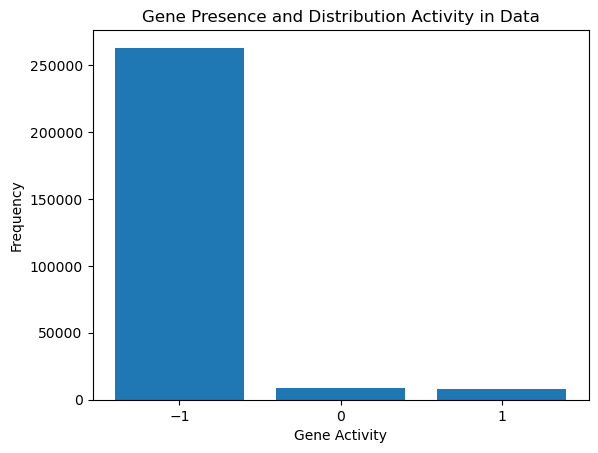

In [6]:
labs_counts = np.unique(allLabs, return_counts = True)
plt.bar(x = labs_counts[0], height = labs_counts[1])
plt.xticks(ticks=labs_counts[0])
plt.title("Gene Presence and Distribution Activity in Data")
plt.xlabel("Gene Activity")
plt.ylabel("Frequency")

The plot above showed us that the majority of the data we had were from non coding regions of genes, which is represented by the -1 label. The coding regions are represented by the labels 0 and 1, where 0 is a region that contains an inactive gene and 1 contains an active gene. This helps us understand why the data we were training on seems to be so small when compared to the entire dataset. The classes {0, 1} are roughly identical to each other in size. 

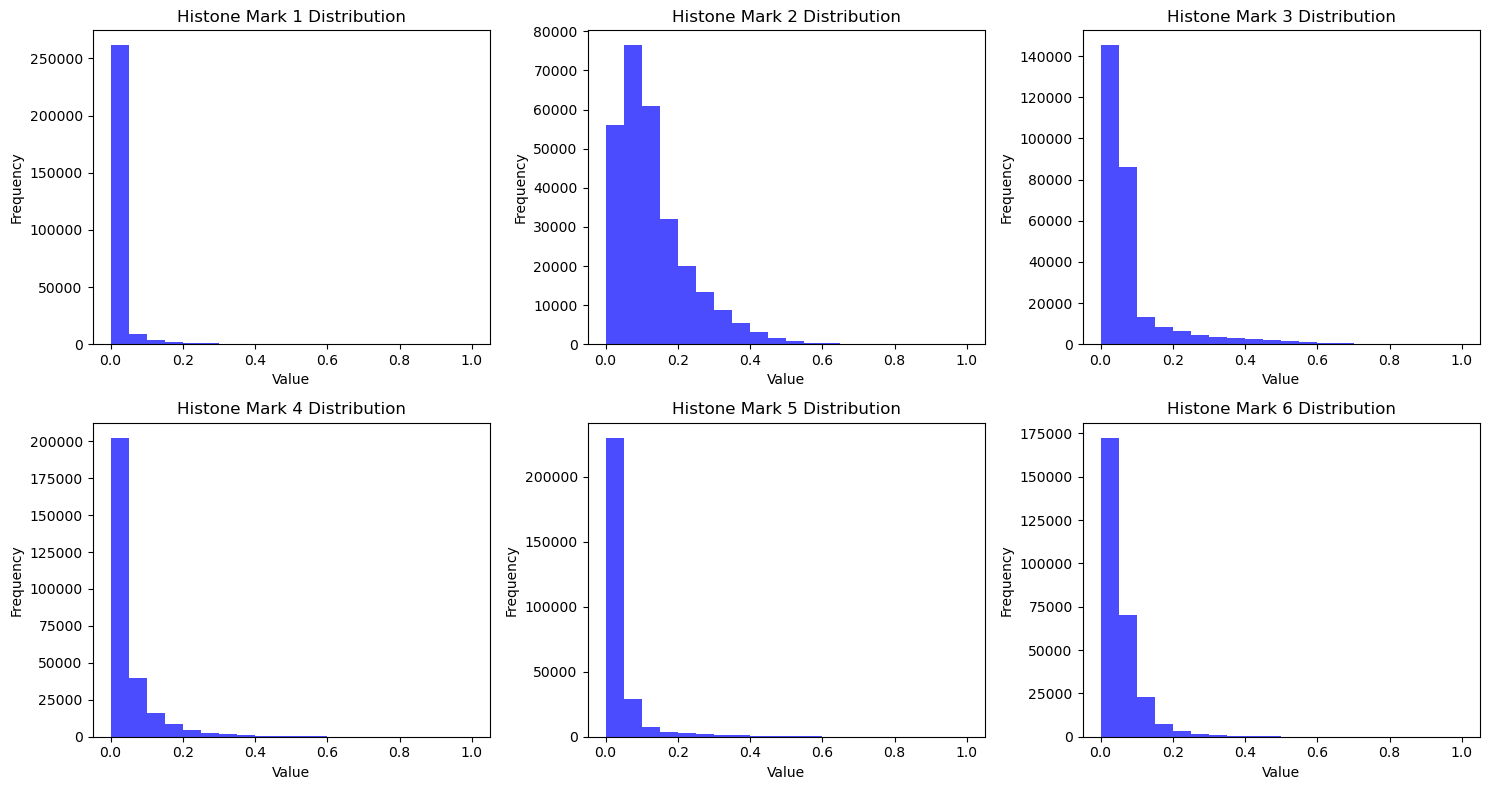

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()
for i in range(6):
    axes[i].hist(X[:, i].numpy(), bins=20, alpha=0.7, color='blue')
    axes[i].set_title(f'Histone Mark {i+1} Distribution')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

The above plot shows the distribution of the activity by histone marker. Histone modifications give us more understanding of the factors affecting gene expression.

#### Helper Functions to train/evaluate models

In [8]:
def train_model_classification(model, graph, max_epoch, learning_rate, targetNode_mask, train_idx, valid_idx, optimizer):
    '''
    Trains model for classification task
    
    Parameters
    ----------
    model [GCN_classification]: Instantiation of model class
    graph [PyG Data class]: PyTorch Geometric Data object representing the graph
    max_epoch [int]: Maximum number of training epochs
    learning_rate [float]: Learning rate
    targetNode_mask [tensor]: Subgraph mask for training nodes
    train_idx [array]: Node IDs corresponding to training set
    valid_idx [array]: Node IDs corresponding to validation set
    optimizer [PyTorch optimizer class]: PyTorch optimization algorithm

    Returns
    -------
    train_loss_vec [array]: Training loss for each epoch
    train_AUROC_vec [array]: Training AUROC score for each epoch
    valid_loss_vec [array]: Validation loss for each epoch
    valid_AUROC_vec [array]: Validation AUROC score for each epoch

    '''
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    graph = graph.to(device)

    optimizer = optimizer
    
    train_labels = to_cpu_npy(graph.y[targetNode_mask[train_idx]])
    valid_labels = to_cpu_npy(graph.y[targetNode_mask[valid_idx]])
    
    train_loss_list = []
    train_AUROC_vec = np.zeros(np.shape(np.arange(max_epoch)))
    valid_loss_list = []
    valid_AUROC_vec = np.zeros(np.shape(np.arange(max_epoch)))

    model.train()
    train_status = True
    
    print('\n')
    for e in list(range(max_epoch)):
        
        if e%100 == 0:
            print("Epoch", str(e), 'out of', str(max_epoch))
        
        model.train()
        train_status = True
        
        optimizer.zero_grad()
        
        ### Only trains on nodes with genes due to masking
        forward_scores = model(graph.x.float(), graph.edge_index, train_status)[targetNode_mask]
        
        train_scores = forward_scores[train_idx]

        train_loss  = model.loss(train_scores, torch.LongTensor(train_labels).to(device))

        train_softmax, _ = model.calc_softmax_pred(train_scores)

        train_loss.backward()
        
        optimizer.step()
            
        ### Calculate training and validation loss, AUROC scores
        model.eval()
        
        valid_scores = forward_scores[valid_idx]
        valid_loss  = model.loss(valid_scores, torch.LongTensor(valid_labels).to(device))
        valid_softmax, _ = model.calc_softmax_pred(valid_scores) 

        train_loss_list.append(train_loss.item())
        train_softmax = to_cpu_npy(train_softmax)
        train_AUROC = roc_auc_score(train_labels, train_softmax[:,1], average="micro")

        valid_loss_list.append(valid_loss.item())
        valid_softmax = to_cpu_npy(valid_softmax)
        valid_AUROC = roc_auc_score(valid_labels, valid_softmax[:,1], average="micro")
        
        train_AUROC_vec[e] = train_AUROC
        valid_AUROC_vec[e] = valid_AUROC

    train_loss_vec = np.reshape(np.array(train_loss_list), (-1, 1))
    valid_loss_vec = np.reshape(np.array(valid_loss_list), (-1, 1))

    return train_loss_vec, train_AUROC_vec, valid_loss_vec, valid_AUROC_vec


def eval_model_classification(model, graph, targetNode_mask, train_idx, valid_idx, test_idx):
    '''
    Runs fully trained classification model and compute evaluation statistics

    Parameters
    ----------
    model [GCN_classification]: Instantiation of model class
    graph [PyG Data class]: PyTorch Geometric Data object representing the graph
    targetNode_mask [tensor]: Mask ensuring model only trains on nodes with genes
    train_idx [array]: Node IDs corresponding to training set;
        analogous for valid_idx and test_idx

    Returns
    -------
    test_AUROC [float]: Test set AUROC score;
        analogous for train_AUROC (training set) and valid_AUPR (validation set)
    test_AUPR [float]: Test set AUPR score
        analogous for train_AUPR (training set) and valid_AUPR (validation set)
    test_pred [array]: Test set predictions;
        analogous for train_pred (training set) and valid_pred (validation set)
    test_labels [array]: Test set labels;
        analagous for train_labels (training set) and valid_labels (validation set)
    '''
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    graph = graph.to(device)
    test_labels = to_cpu_npy(graph.y[targetNode_mask[test_idx]])
    
    model.eval()
    train_status=False

    forward_scores = model(graph.x.float(), graph.edge_index, train_status)[targetNode_mask]

    test_scores = forward_scores[test_idx]
    test_softmax, test_pred = model.calc_softmax_pred(test_scores) 
    
    test_softmax = to_cpu_npy(test_softmax)
    test_pred = to_cpu_npy(test_pred)
    test_AUROC = roc_auc_score(test_labels, test_softmax[:,1], average="micro")
    test_precision, test_recall, thresholds = precision_recall_curve(test_labels, test_softmax[:,1])
    test_AUPR = auc(test_recall, test_precision)
    # test_F1 = f1_score(test_labels, test_pred, average="micro")
    
    train_scores = forward_scores[train_idx]
    train_labels = to_cpu_npy(graph.y[targetNode_mask[train_idx]])
    train_softmax, train_pred = model.calc_softmax_pred(train_scores) 
    train_pred = to_cpu_npy(train_pred)
    train_softmax = to_cpu_npy(train_softmax)
    train_precision, train_recall, thresholds = precision_recall_curve(train_labels, train_softmax[:,1])
    train_AUPR = auc(train_recall, train_precision)
    # train_F1 = f1_score(train_labels, train_pred, average="micro")

    valid_scores = forward_scores[valid_idx]
    valid_labels = to_cpu_npy(graph.y[targetNode_mask[valid_idx]])
    valid_softmax, valid_pred = model.calc_softmax_pred(valid_scores) 
    valid_pred = to_cpu_npy(valid_pred)
    valid_softmax = to_cpu_npy(valid_softmax)
    valid_precision, valid_recall, thresholds = precision_recall_curve(valid_labels, valid_softmax[:,1])
    valid_AUPR = auc(valid_recall, valid_precision)
    # valid_F1 = f1_score(valid_labels, valid_pred, average="micro")

    return test_AUROC, test_AUPR, test_pred, test_labels, train_AUPR, train_pred, train_labels, \
        valid_AUPR, valid_pred, valid_labels


def train_model_regression(model, graph, max_epoch, learning_rate, targetNode_mask, train_idx, valid_idx, optimizer):
    '''
    Trains model for regression task
    
    Parameters
    ----------
    model [GCN_classification]: Instantiation of model class
    graph [PyG Data class]: PyTorch Geometric Data object representing the graph
    max_epoch [int]: Maximum number of training epochs
    learning_rate [float]: Learning rate
    targetNode_mask [tensor]: Subgraph mask for training nodes
    train_idx [array]: Node IDs corresponding to training set
    valid_idx [array]: Node IDs corresponding to validation set
    optimizer [PyTorch optimizer class]: PyTorch optimization algorithm

    Returns
    -------
    train_loss_vec [array]: Training loss for each epoch;
        analagous for valid_loss_vec (validation set)
    train_pearson_vec [array]: Training PCC for each epoch;
        analogous for valid_pearson_vec (validation set)
    '''
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    graph = graph.to(device)

    optimizer = optimizer
    
    train_labels = to_cpu_npy(graph.y[targetNode_mask[train_idx]])
    valid_labels = to_cpu_npy(graph.y[targetNode_mask[valid_idx]])
    
    train_loss_list = []
    train_pearson_vec = np.zeros(np.shape(np.arange(max_epoch)))
    valid_loss_list = []
    valid_pearson_vec = np.zeros(np.shape(np.arange(max_epoch)))

    model.train()
    train_status = True
    
    print('\n')
    for e in list(range(max_epoch)):
        
        if e%100 == 0:
            print("Epoch", str(e), 'out of', str(max_epoch))
        
        model.train()
        train_status = True
        
        optimizer.zero_grad()
        
        ### Only trains on nodes with genes due to masking
        forward_scores = model(graph.x.float(), graph.edge_index, train_status)[targetNode_mask]
        
        train_scores = forward_scores[train_idx]

        train_loss  = model.loss(train_scores, torch.FloatTensor(train_labels).to(device))

        train_loss.backward()
        
        optimizer.step()
            
        ### Calculate training and validation loss, AUROC scores
        model.eval()
        
        train_scores = to_cpu_npy(train_scores)
        train_pearson = calc_pearson(train_scores, train_labels)
        train_loss_list.append(train_loss.item())
        
        valid_scores = forward_scores[valid_idx]
        valid_loss  = model.loss(valid_scores, torch.FloatTensor(valid_labels).to(device))
        valid_scores = to_cpu_npy(valid_scores)
        valid_pearson  = calc_pearson(valid_scores, valid_labels)
        valid_loss_list.append(valid_loss.item())
        
        train_pearson_vec[e] = train_pearson
        valid_pearson_vec[e] = valid_pearson

    train_loss_vec = np.reshape(np.array(train_loss_list), (-1, 1))
    valid_loss_vec = np.reshape(np.array(valid_loss_list), (-1, 1))

    return train_loss_vec, train_pearson_vec, valid_loss_vec, valid_pearson_vec


def eval_model_regression(model, graph, targetNode_mask, train_idx, valid_idx, test_idx):
    '''
    Runs fully trained regression model and compute evaluation statistics

    Parameters
    ----------
    model [GCN_classification]: Instantiation of model class
    graph [PyG Data class]: PyTorch Geometric Data object representing the graph
    targetNode_mask [tensor]: Mask ensuring model only trains on nodes with genes
    train_idx [array]: Node IDs corresponding to training set;
        analogous for valid_idx and test_idx

    Returns
    -------
    test_pearson [float]: PCC for test set;
        analogous for train_pearson (training set) and valid_pearson (validation set)
    test_pred [array]: Test set predictions;
        analogous for train_pred (training set) and valid_pred (validation set)
    test_labels [array]: Test set labels (expression values);
        analagous for train_labels (training set) and valid_labels (validation set)

    '''
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    graph = graph.to(device)
    
    model.eval()
    train_status=False

    forward_scores = model(graph.x.float(), graph.edge_index, train_status)[targetNode_mask]

    test_scores = forward_scores[test_idx]
    test_pred = to_cpu_npy(test_scores)
    test_labels = to_cpu_npy(graph.y[targetNode_mask[test_idx]])
    test_pearson = calc_pearson(test_pred, test_labels)

    train_scores = forward_scores[train_idx]
    train_pred = to_cpu_npy(train_scores)
    train_labels = to_cpu_npy(graph.y[targetNode_mask[train_idx]])
    train_pearson = calc_pearson(train_pred, train_labels)

    valid_scores = forward_scores[valid_idx]
    valid_pred = to_cpu_npy(valid_scores)
    valid_labels = to_cpu_npy(graph.y[targetNode_mask[valid_idx]])
    valid_pearson = calc_pearson(valid_pred, valid_labels)

    return test_pearson, test_pred, test_labels, train_pearson, train_pred, train_labels, \
        valid_pearson, valid_pred, valid_labels
        

def calc_pearson(scores, targets):
    '''
    Calculates Pearson correlation coefficient (PCC) between predicted \
        expression levels and true expression levels

    Parameters
    ----------
    scores [array]: Predicted expression levels
    targets [array]: True expression levels

    Returns
    -------
    pcc [float]: Pearson correlation coefficient

    '''
    pcc, _ = pearsonr(scores, targets)
            
    return pcc
    
    
def to_cpu_npy(x):
    '''
    Simple helper function to transfer GPU tensors to CPU numpy matrices

    Parameters
    ----------
    x [tensor]: PyTorch tensor stored on GPU

    Returns
    -------
    new_x [array]: Numpy array stored on CPU

    '''

    new_x = x.cpu().detach().numpy()
    
    return new_x

# GC-MERGE Runs

In [9]:
#hyperparameter and model definitions
cell_line = 'E116'
max_epoch = 1000
learning_rate = 1e-4
num_graph_conv_layers = 2
graph_conv_embed_size = 256
num_lin_layers = 3
lin_hidden_size = 256
regression_flag = 0
random_seed = 0

chip_res = 10000
hic_res = 10000
num_hm = 6
num_feat = int((hic_res/chip_res)*num_hm)
num_classes = 2 if regression_flag == 0 else 1

In [10]:
print('Cell line:', cell_line)
print('ChIP-seq resolution:', str(chip_res))
print('\n')
print('Training set: 70%')
print('Validation set: 15%')
print('Testing set: 15%')
print('\n')
print('Model hyperparameters: ')
print('Number of epochs:', max_epoch)
print('Learning rate:', learning_rate)
print('Number of graph convolutional layers:', str(num_graph_conv_layers))
print('Graph convolutional embedding size:', graph_conv_embed_size)
print('Number of linear layers:', str(num_lin_layers))
print('Linear hidden layer size:', lin_hidden_size)

# random_seed = random.randint(0,10000)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

###Test for GPU availability
cuda_flag = torch.cuda.is_available()
if cuda_flag:  
  dev = "cuda" 
else:
  dev = "cpu"  
device = torch.device(dev)

Cell line: E116
ChIP-seq resolution: 10000


Training set: 70%
Validation set: 15%
Testing set: 15%


Model hyperparameters: 
Number of epochs: 1000
Learning rate: 0.0001
Number of graph convolutional layers: 2
Graph convolutional embedding size: 256
Number of linear layers: 3
Linear hidden layer size: 256


Created Function to reuse data preparation steps over mulitple runs 

In [11]:
###Load input files
def prepare_data(cell_line, regression_flag, base_path):
    save_dir = os.path.join(base_path, 'data', cell_line, 'saved_runs')
    hic_sparse_mat_file = os.path.join(base_path, 'data', cell_line, 'hic_sparse.npz')
    np_nodes_lab_genes_file = os.path.join(base_path, 'data',  cell_line, \
        'np_nodes_lab_genes_reg' + str(regression_flag) + '.npy')
    np_hmods_norm_all_file = os.path.join(base_path, 'data', cell_line, \
        'np_hmods_norm_chip_' + str(chip_res) + 'bp.npy')
    df_genes_file = os.path.join(base_path, 'data', cell_line, 'df_genes_reg' + str(regression_flag) + '.pkl')
    df_genes = pd.read_pickle(df_genes_file)
    
    mat = load_npz(hic_sparse_mat_file)
    allNodes_hms = np.load(np_hmods_norm_all_file)
    hms = allNodes_hms[:, 1:] #only includes features, not node ids
    X = torch.tensor(hms).float().reshape(-1, num_feat) 
    allNodes = allNodes_hms[:, 0].astype(int)
    geneNodes_labs = np.load(np_nodes_lab_genes_file)

    geneNodes = geneNodes_labs[:, -2].astype(int)
    allLabs = -1*np.ones(np.shape(allNodes))

    targetNode_mask = torch.tensor(geneNodes).long()

    if regression_flag == 0:
        geneLabs = geneNodes_labs[:, -1].astype(int)
        allLabs[geneNodes] = geneLabs
        Y = torch.tensor(allLabs).long()
    else:
        geneLabs = geneNodes_labs[:, -1].astype(float)
        allLabs[geneNodes] = geneLabs
        Y = torch.tensor(allLabs).float()

    extract = torch_geometric.utils.from_scipy_sparse_matrix(mat)
    data = torch_geometric.data.Data(edge_index = extract[0], edge_attr = extract[1], x = X, y = Y)
    G = data
    
    ###Randomize node order and split into 70%/15%/15% training/validation/test sets
    torch.manual_seed(0)
    pred_idx_shuff = torch.randperm(targetNode_mask.shape[0])
    fin_train = np.floor(0.7*pred_idx_shuff.shape[0]).astype(int)
    fin_valid = np.floor(0.85*pred_idx_shuff.shape[0]).astype(int)
    
    return G, targetNode_mask

In [12]:
graph_conv_embed_size = 256
num_graph_conv_layers = 2

graph_conv_layer_sizes = [num_feat] + \
    [int(max(graph_conv_embed_size, lin_hidden_size)) \
          for i in np.arange(1, num_graph_conv_layers, 1)] + [lin_hidden_size]

graph_lin_hidden_sizes = [graph_conv_layer_sizes[-1]] + \
    [int(max(lin_hidden_size, num_classes)) \
          for i in np.arange(1, num_lin_layers, 1)] + [num_classes]

graph_lin_hidden_sizes_reg = [graph_conv_layer_sizes[-1]] + \
    [int(max(lin_hidden_size, num_classes)) \
          for i in np.arange(1, num_lin_layers, 1)] + [1]

In [13]:
num_classes_reg = 1
lin_hidden_sizes = [num_feat] + [int(max(lin_hidden_size, num_classes)) for i in np.arange(1, num_lin_layers, 1)] + [num_classes]
lin_hidden_sizes_reg = [num_feat] + [int(max(lin_hidden_size, num_classes_reg)) for i in np.arange(1, num_lin_layers, 1)] + [num_classes_reg]

print(lin_hidden_sizes)

[6, 256, 256, 2]


In [14]:
cell_lines = ['E116', 'E122', 'E123']
classification_res = pd.DataFrame(columns=cell_lines)
gcn_regression_res = pd.DataFrame(columns=cell_lines)

In the cell below, we are training GC-MERGE Classifier on three different cell lines

In [15]:
gcn_auroc = []
for cell_line in cell_lines:
    print(f'\nTraining Cell Line {cell_line}...')

    train_idx = torch.load(f'../train-test-split/{cell_line}/train_idx.pt')
    valid_idx = torch.load(f'../train-test-split/{cell_line}/valid_idx.pt')
    test_idx = torch.load(f'../train-test-split/{cell_line}/test_idx.pt')
    
    G, targetNode_mask = prepare_data(cell_line=cell_line, regression_flag = regression_flag, base_path = src_dir)
    
    model = GCN_classification(num_feat, num_graph_conv_layers, graph_conv_layer_sizes, num_lin_layers, graph_lin_hidden_sizes, num_classes)
    optimizer = torch.optim.Adam(filter(lambda p : p.requires_grad, model.parameters()), lr = learning_rate)

    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    print(f'Number of Parameters: {sum([np.prod(p.size()) for p in model_parameters])}')

    train_loss_vec, train_AUROC_vec, valid_loss_vec, valid_AUROC_vec = \
    train_model_classification(model, G, max_epoch, learning_rate, targetNode_mask, train_idx, valid_idx, optimizer)

    test_AUROC, test_AUPR, test_pred, test_labels, train_AUPR, train_pred, train_labels, \
        valid_AUPR, valid_pred, valid_labels = \
            eval_model_classification(model, G, targetNode_mask, train_idx, valid_idx, test_idx)
    
    gcn_auroc.append(test_AUROC)
    print(test_AUROC)
    
classification_res.loc['GCN'] = gcn_auroc
classification_res


Training Cell Line E116...
Number of Parameters: 266754


Epoch 0 out of 1000
Epoch 100 out of 1000
Epoch 200 out of 1000
Epoch 300 out of 1000
Epoch 400 out of 1000
Epoch 500 out of 1000
Epoch 600 out of 1000
Epoch 700 out of 1000
Epoch 800 out of 1000
Epoch 900 out of 1000
0.912007524431305

Training Cell Line E122...
Number of Parameters: 266754


Epoch 0 out of 1000
Epoch 100 out of 1000
Epoch 200 out of 1000
Epoch 300 out of 1000
Epoch 400 out of 1000
Epoch 500 out of 1000
Epoch 600 out of 1000
Epoch 700 out of 1000
Epoch 800 out of 1000
Epoch 900 out of 1000
0.9071962470840386

Training Cell Line E123...
Number of Parameters: 266754


Epoch 0 out of 1000
Epoch 100 out of 1000
Epoch 200 out of 1000
Epoch 300 out of 1000
Epoch 400 out of 1000
Epoch 500 out of 1000
Epoch 600 out of 1000
Epoch 700 out of 1000
Epoch 800 out of 1000
Epoch 900 out of 1000
0.9263978589585078


,E116,E122,E123
GCN,0.912008,0.907196,0.926398


In [16]:
mlp_auroc = []

for cell_line in ['E116', 'E122', 'E123']:

    train_idx = torch.load(f'../train-test-split/{cell_line}/train_idx.pt')
    valid_idx = torch.load(f'../train-test-split/{cell_line}/valid_idx.pt')
    test_idx = torch.load(f'../train-test-split/{cell_line}/test_idx.pt')
    
    print(f'\nTraining Cell Line {cell_line}...')
    G, targetNode_mask = prepare_data(cell_line=cell_line, regression_flag = regression_flag, base_path = src_dir)
    
    model = MLP_classification(num_feat, num_lin_layers, lin_hidden_sizes, num_classes)
    optimizer = torch.optim.Adam(filter(lambda p : p.requires_grad, model.parameters()), lr = learning_rate)
    
    train_loss_vec, train_AUROC_vec, valid_loss_vec, valid_AUROC_vec = \
    train_model_classification(model, G, max_epoch, learning_rate, targetNode_mask, train_idx, valid_idx, optimizer)

    test_AUROC, test_AUPR, test_pred, test_labels, train_AUPR, train_pred, train_labels, \
        valid_AUPR, valid_pred, valid_labels = \
            eval_model_classification(model, G, targetNode_mask, train_idx, valid_idx, test_idx)
    
    mlp_auroc.append(test_AUROC)
    
classification_res.loc['MLP'] = mlp_auroc
classification_res


Training Cell Line E116...


Epoch 0 out of 1000
Epoch 100 out of 1000
Epoch 200 out of 1000
Epoch 300 out of 1000
Epoch 400 out of 1000
Epoch 500 out of 1000
Epoch 600 out of 1000
Epoch 700 out of 1000
Epoch 800 out of 1000
Epoch 900 out of 1000

Training Cell Line E122...


Epoch 0 out of 1000
Epoch 100 out of 1000
Epoch 200 out of 1000
Epoch 300 out of 1000
Epoch 400 out of 1000
Epoch 500 out of 1000
Epoch 600 out of 1000
Epoch 700 out of 1000
Epoch 800 out of 1000
Epoch 900 out of 1000

Training Cell Line E123...


Epoch 0 out of 1000
Epoch 100 out of 1000
Epoch 200 out of 1000
Epoch 300 out of 1000
Epoch 400 out of 1000
Epoch 500 out of 1000
Epoch 600 out of 1000
Epoch 700 out of 1000
Epoch 800 out of 1000
Epoch 900 out of 1000


,E116,E122,E123
GCN,0.912008,0.907196,0.926398
MLP,0.908909,0.896096,0.918319


In [1]:
classification_res.to_csv('../results.csv')

NameError: name 'classification_res' is not defined

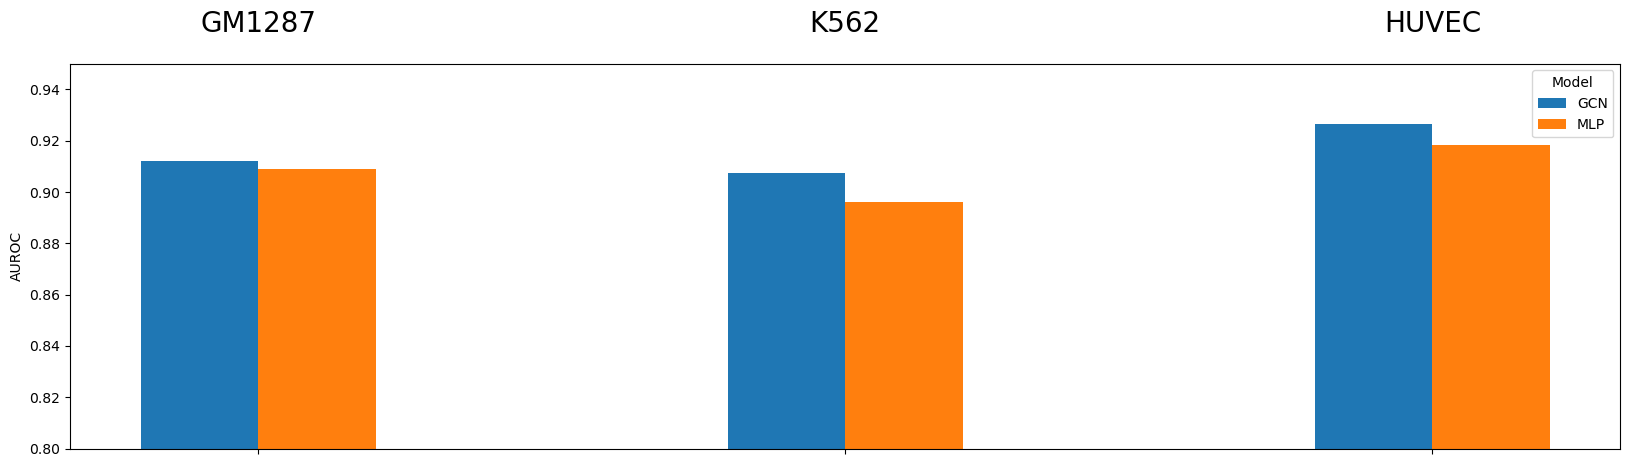

In [18]:
cell_line_alias = {'E116': 'GM1287', 'E123': 'K562', 'E122': 'HUVEC'}

fig, ax = plt.subplots(figsize=(20, 5))
bar_width = 0.2
index = np.arange(len(classification_res.columns))

for i, model in enumerate(classification_res.index):
    ax.bar(index + i * bar_width, classification_res.loc[model], bar_width, label=model)

ax.set_ylabel('AUROC')
ax.set_ylim(0.8, 0.95)
ax.set_xticks(index + bar_width * (len(classification_res.index) - 1) / 2)
ax.set_xticklabels([])  # Remove the default x-tick labels

for i in range(len(cell_line_alias)):
    ax.text(index[i] + bar_width * (len(classification_res.index) - 1) / 2, 
            0.96,
            cell_line_alias[list(cell_line_alias.keys())[i]],
            ha='center', va='bottom', fontsize=20)

ax.legend(title='Model')
plt.show()

In the cell below, we run GC-MERGE Regressor for the 3 cell lines

In [21]:
GCN_regression(num_feat, num_graph_conv_layers, graph_conv_layer_sizes, num_lin_layers, graph_lin_hidden_sizes, num_classes)

GCN_regression(
  (conv1): SAGEConvCat(6, 256)
  (conv2): SAGEConvCat(256, 256)
  (lin1): Linear(in_features=256, out_features=256, bias=True)
  (lin2): Linear(in_features=256, out_features=256, bias=True)
  (lin3): Linear(in_features=256, out_features=2, bias=True)
  (loss_calc): MSELoss()
)

In [22]:
gcn_pearson = {}
gcn_preds_reg_E116, gcn_preds_lab_E116 = [], []
gcn_preds_reg_E122, gcn_preds_lab_E122 = [], []
gcn_preds_reg_E123, gcn_preds_lab_E123 = [], []

graph_lin_hidden_sizes[-1] -= 1

for cell_line in cell_lines:
    
    train_idx = torch.load(f'../train-test-split/{cell_line}/train_idx.pt')
    valid_idx = torch.load(f'../train-test-split/{cell_line}/valid_idx.pt')
    test_idx = torch.load(f'../train-test-split/{cell_line}/test_idx.pt')
    
    print(f'\nTraining Cell Line {cell_line}...')
    G, targetNode_mask = prepare_data(cell_line=cell_line, regression_flag = 1, base_path = src_dir)
    
    model = GCN_classification(num_feat, num_graph_conv_layers, graph_conv_layer_sizes, num_lin_layers, graph_lin_hidden_sizes, num_classes_reg)
    optimizer = torch.optim.Adam(filter(lambda p : p.requires_grad, model.parameters()), lr = learning_rate)
    
    train_loss_vec, train_pearson_vec, valid_loss_vec, valid_pearson_vec = \
        train_model_regression(model, G, max_epoch, learning_rate, targetNode_mask, train_idx, valid_idx, optimizer)
    
    test_pearson, test_pred, test_labels, train_pearson, train_pred, train_labels, \
        valid_pearson, valid_pred, valid_labels = \
            eval_model_regression(model, G, targetNode_mask, train_idx, valid_idx, test_idx)
    
    if cell_line == 'E116':
        gcn_preds_reg_E116.append(test_pred)
        gcn_preds_lab_E116.append(test_labels)
    elif cell_line == 'E122':
        gcn_preds_reg_E122.append(test_pred)
        gcn_preds_lab_E122.append(test_labels)
    elif cell_line == 'E123':
        gcn_preds_reg_E123.append(test_pred)
        gcn_preds_lab_E123.append(test_labels)
    
    gcn_pearson[cell_line] = test_pearson
    
gcn_regression_res.loc['GCN'] = gcn_pearson
gcn_regression_res


Training Cell Line E116...


Epoch 0 out of 1000


RuntimeError: "nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Float'

In [ ]:
mlp_pearson = []

for cell_line in ['E116', 'E122', 'E123']:
    print(f'\nTraining Cell Line {cell_line}...')
    G, targetNode_mask, train_idx, valid_idx, test_idx = prepare_data(cell_line=cell_line, regression_flag = 1, base_path = src_dir)
    
    model = MLP_regression(num_feat, num_lin_layers, lin_hidden_sizes_reg, num_classes_reg)
    optimizer = torch.optim.Adam(filter(lambda p : p.requires_grad, model.parameters()), lr = learning_rate)
    
    train_loss_vec, train_pearson_vec, valid_loss_vec, valid_pearson_vec = \
        train_model_regression(model, G, max_epoch, learning_rate, targetNode_mask, train_idx, valid_idx, optimizer)
    
    test_pearson, test_pred, test_labels, train_pearson, train_pred, train_labels, \
        valid_pearson, valid_pred, valid_labels = \
            eval_model_regression(model, G, targetNode_mask, train_idx, valid_idx, test_idx)
    
    mlp_pearson.append(test_pearson)
    
gcn_regression_res.loc['MLP'] = mlp_pearson
gcn_regression_res

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
bar_width = 0.2
index = np.arange(len(gcn_regression_res.columns))

for i, model in enumerate(gcn_regression_res.index):
    ax.bar(index + i * bar_width, gcn_regression_res.loc[model], bar_width, label=model)

# Add labels, title, and legend
ax.set_ylabel('PCC')
ax.set_ylim(0.7, 0.83)
ax.set_xticks(index + bar_width * (len(gcn_regression_res.index) - 1) / 2)
ax.set_xticklabels([])  # Remove x-tick labels as specified

ax.legend(title='Model')
plt.show()

In [ ]:
intercept = 0.1
fig, axs = plt.subplots(1, 3, figsize=(20 ,5))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

pcc_E116 = gcn_pearson['E116']
axs[0].scatter(gcn_preds_reg_E116[0], gcn_preds_lab_E116[0])
x_vals_E116 = np.linspace(0, 3, 100)
y_vals_E116 = pcc_E116 * x_vals_E116 + intercept
axs[0].plot(x_vals_E116, y_vals_E116, color='red', lw=2, label=f"Slope = {pcc_E116}, Intercept = {intercept}")
axs[0].text(0.5, 3.5, f"PCC = {pcc_E116:.2f}", fontsize=14, color='black')
axs[0].set_xlabel("Observed Log10 Expression")
axs[0].set_ylabel("Predicted Log10 Expression")
axs[0].set_xlim(0, 4)
axs[0].set_ylim(0, 4)

pcc_E123 = gcn_pearson['E123']
axs[1].scatter(gcn_preds_reg_E123[0], gcn_preds_lab_E123[0])
x_vals_E123 = np.linspace(0, 3, 100)
y_vals_E123 = pcc_E123 * x_vals_E123 + intercept
axs[1].plot(x_vals_E123, y_vals_E123, color='red', lw=2, label=f"Slope = {pcc_E123}, Intercept = {intercept}")
axs[1].text(0.5, 3.5, f"PCC = {pcc_E123:.2f}", fontsize=14, color='black')
axs[1].set_xlabel("Observed Log10 Expression")
axs[1].set_yticks([])
axs[1].set_xlim(0, 4)
axs[1].set_ylim(0, 4)

pcc_E122 = gcn_pearson['E122']
axs[2].scatter(gcn_preds_reg_E122[0], gcn_preds_lab_E122[0])
x_vals_E122 = np.linspace(0, 3, 100)
y_vals_E122 = pcc_E122 * x_vals_E122 + intercept
axs[2].plot(x_vals_E122, y_vals_E122, color='red', lw=2, label=f"Slope = {pcc_E122}, Intercept = {intercept}")
axs[2].text(0.5, 3.5, f"PCC = {pcc_E122:.2f}", fontsize=14, color='black')
axs[2].set_xlabel("Observed Log10 Expression")
axs[2].set_yticks([])
axs[2].set_xlim(0, 4)
axs[2].set_ylim(0, 4)

fig.show()

# MLP Runs

Code for defining the models can be found in baseline_mdl_classes.py. For MLP, we used the same architecture for the network as GC-MERGE, but removed the GraphSAGE layers. This eliminated the graph feature of the model and skipped to running the node features through a fully connected network to make predictions.

# CNN Runs

### All CNN implementation is in CNN.ipynb

#### Question From Midterm Report:

**3:** Let’s say your training a model and the accuracy for the model plateaued after the first epoch. I.e. the accuracy remains the same for every epoch. List 5 factors that could cause this and how you would address each of them.

**Answer:**

1. Check the learning rate. If the learning rate is too high, training could converge quickly and plateau after the first epoch. It also could have quickly found a local minimum, so the best solution is not found. A learning rate that is too low would not be a likely cause of this issue, as training would converge slower, not faster. If a low learning rate still causes the training to plateau, another issue is likely the cause.

2. Check the distribution of classes. If the model is a classification model, the classes could be imbalanced. For example, 94% of data could be in one class, and the remaining 6% could be scattered across 5 other classes. This would cause the training to only be able to detect some patterns from the data, or cause it to only predict the class containing 94% of the data every time. Therefore, learning doesn't improve, and it plateaus after the first epoch. This can be fixed by oversampling the minority classes or undersampling the majority class to create a more even distribution for training. Another option is to weigh the minority classes much higher than the majority class in training.

3. Check the batch size. If the batch size is really small, training accuracy could increase quickly and stop. If the batch size is too large, it could overfit. Finding the right batch size through hyperparameter tuning would ensure both issues don't occur.

4. Check if the model is too large. If the model is too large (and/or the learning rate is too high), it could cause training to plateau early. Using regularization such as dropout, L1, or L2 could help reduce the complexity of the model to the point where training doesn't plateau after 1 epoch.

5. Check the model parameters. Perhaps the choices of parameters such as number of layers, input size, output size, or hidden dimension size are not optimal for the model. Using grid search or other hyperparameter tuning methods to find optimal values for each of these could help the training stagnation issue.